## Using Ponder + Snowpark ML for Healthcare Data Analysis

<div class="alert alert-block alert-info"> <b>Before we get started: </b> 
    <ul style="list-style-type: none;margin: 0;padding: 0;">
        <li>✍️ To run this notebook, you need to have Ponder installed and set up on your machine. If you have not done so already, please refer to our <a href="https://docs.ponder.io/getting_started/quickstart.html">Quickstart guide</a> to get started.</li>
        <li>📖 Otherwise, if you're just interested in browsing through the notebook, keep reading below!</li>
    </ul>
</div>

In [ ]:
#Note: Packages must be installed in this order to avoid pandas version conflicts
! pip install snowflake-ml-python "ponder[snowflake]" 

With the growth of electronic health records, healthcare providers store, process, and analyze information about patients, their medical history, treatment, and outcomes. Effective analysis of electronic health records has been shown to improve the patient care experience, support clinical decision-making, and advance the frontiers of medical research.

In this post, we will walk through a end-to-end machine learning workflow to show how you can use Ponder and Snowpark ML to analyze electronic health records directly in your data warehouse. Note that this blogpost builds off of our [earlier blogpost](https://ponder.io/healthcare-analytics-in-python-using-ponder/) and additionally demonstrates how you can use Snowflake's [Snowpark ML modeling API](https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-modeling) to perform machine learning in your database, rather than having to pull your data out of Snowflake to use sklearn in-memory.

You can download the notebook associated with this post [here](https://github.com/ponder-org/ponder-blog/blob/main/snowflake/example/Ponder%20Snowpark%20ML.ipynb).

<img src="https://ponder.io/wp-content/uploads/2023/08/snowpark_ml.png"></img>

### The MIMIC-III Clinical Dataset

In this blog post, we will be looking at the [MIMIC-III demo dataset](https://physionet.org/content/mimiciii-demo/1.4/). The MIMIC-III Clinical Database contains deidentified health-related data of patients who stayed in an intensive care unit (ICU) at the Beth Israel Deaconess Medical Center in Boston. The demo dataset contains records for 100 patients across three tables `PATIENTS`, `ICUSTAYS`, and `ADMISSIONS`. 

Citation: 
```
Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific data, 3, 160035.
```

You can download the datasets [here](https://github.com/ponder-org/ponder-datasets/tree/main/mimic-iii) or use [our dataset upload script](https://github.com/ponder-org/ponder-notebooks/blob/main/snowflake/populate_mimic3.py) to load it to Snowflake.

### What is Ponder? 

Ponder lets you run pandas directly in your data warehouse. Data teams can interact with their data through their familiar pandas-native experience, while enjoying the scalability and security benefits that come with a modern cloud data warehouses. You can learn more about Ponder in our [recent blogpost](https://ponder.io/run-pandas-on-1tb-directly-in-your-data-warehouse/) and [sign up here](https://ponder.io/product/) to try out Ponder today. 

In [1]:
import os; os.chdir("..")
import credential

In [2]:
import ponder
ponder.init()

Ponder uses your data warehouse as an engine, so we first need to establish a connection with Snowflake in order to start querying the data. The code below shows how you can set up the database connection.

In [3]:
credential.params["database"] = "MIMIC3"
import snowflake.connector
# Create a Ponder Snowflake Connections object
snowflake_con = snowflake.connector.connect(
    user=credential.params["user"],
    password=credential.params["password"],
    account=credential.params["account"],
    role=credential.params["role"],
    database=credential.params["database"],
    schema=credential.params["schema"],
    warehouse=credential.params["warehouse"]
)

In [4]:
import modin.pandas as pd

Once we have connected to the warehouse, we can use the `pd.read_sql` command to connect to our `ICUSTAYS` and `PATIENTS` table. Note that this creates a dataframe that points to those tables without the data being loaded in memory!

In [5]:
icu = pd.read_sql("ICUSTAYS",con=snowflake_con)
patients = pd.read_sql("PATIENTS",con=snowflake_con)

```python
# Optional: If you didn't load the dataset to Snowflake earlier, you can run the following commands instead. 
ponder.configure(default_connection=snowflake_con)
icu = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/mimic-iii/ICUSTAYS.csv?raw=True")
patients = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/mimic-iii/PATIENTS.csv?raw=True")
```

Now we have connected to the two tables in our warehouse, we can operate on it just like you typically do with any pandas dataframe. Here, we join the two tables on the patient identifier `subject_id`.

In [6]:
df = patients.merge(icu,on="subject_id")

We drop the `row_id` columns, which is just a record ID from the database.

In [7]:
df = df.drop(list(df.filter(regex="row_id")),axis=1)

### Exploratory Data Analysis: Dataset Overview

Exploratory data analysis is a important first step in any data science project that helps uncover trends, patterns, and insights that inform subsequent analyses.

To start off, let's look at the descriptive statistics to get an overview of the dataset.

In [8]:
df.describe()

,subject_id,expire_flag,hadm_id,icustay_id,first_wardid,last_wardid,los
count,136.000000,136.0,136.000000,136.000000,136.000000,136.000000,136.000000
mean,28263.485294,1.0,153259.566176,250980.470588,34.470588,34.022059,4.452457
std,16008.281510,0.0,28054.220280,28455.125832,18.876182,19.280951,6.196828
min,10006.000000,1.0,100375.000000,201006.000000,7.000000,7.000000,0.105900
25%,10089.750000,1.0,129028.000000,224359.250000,14.750000,14.000000,1.233525
50%,40307.000000,1.0,157724.000000,250055.000000,33.000000,33.000000,2.111450
75%,42207.000000,1.0,174896.500000,277279.250000,52.000000,52.000000,4.329050
max,44228.000000,1.0,199395.000000,298685.000000,57.000000,57.000000,35.406500


In [9]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      136 non-null    int32  
 1   gender          136 non-null    object 
 2   dob             136 non-null    object 
 3   dod             136 non-null    object 
 4   dod_hosp        88 non-null     object 
 5   dod_ssn         108 non-null    object 
 6   expire_flag     136 non-null    int8   
 7   hadm_id         136 non-null    int32  
 8   icustay_id      136 non-null    int32  
 9   dbsource        136 non-null    object 
 10  first_careunit  136 non-null    object 
 11  last_careunit   136 non-null    object 
 12  first_wardid    136 non-null    int8   
 13  last_wardid     136 non-null    int8   
 14  intime          136 non-null    object 
 15  outtime         136 non-null    object 
 16  los             136 non-null    float64
dtypes: float64(1), int32(3), int8(

We want to understand the correlation between the patient's age and their average length of stay in the ICU. To do this, we must first convert the timestamps into datetime objects.

In [10]:
df["intime"] = pd.to_datetime(df["intime"])
df["outtime"] = pd.to_datetime(df["outtime"])
df["dob"] = pd.to_datetime(df["dob"])

Then to compute the patient's length of stay, we simply subtract the the time the patient exits the ICU (`outtime`) from the time they enter (`intime`).

In [11]:
df["length_of_stay"] = (df["outtime"]-df["intime"])/pd.Timedelta('1 hour')

In [12]:
df["age"] = df["intime"].dt.year-df["dob"].dt.year

Finally, we filter out outlier entries where age is listed as above 100.

In [13]:
df = df[df["age"]<100]

To look at the correlation between these variables, we plot them on a scatterplot.

<Axes: xlabel='age', ylabel='length_of_stay'>

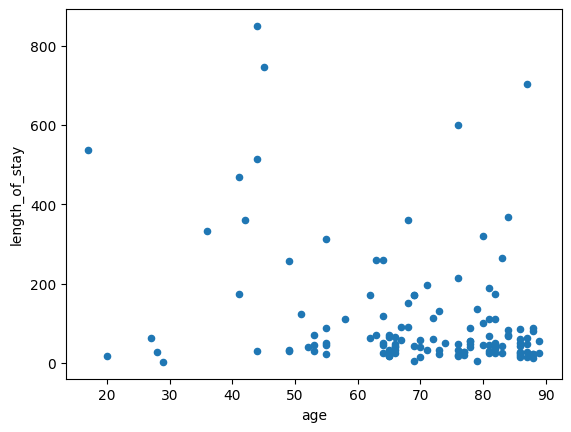

In [14]:
df.plot("age","length_of_stay",kind="scatter")

We see here that there is a concentrated cluster of ICU patients between 50-90 and most patients don't stay for more than 200 hours, but there are some wild outliers to this distribution.

Outside of the ICU stay information, we also want to look at the hospital admissions record to understand what happened *before* the patients were admitted to the ICU. 

In [15]:
admissions = pd.read_sql("ADMISSIONS",con=snowflake_con)

```python
#Optional: If you didn't load the dataset to Snowflake earlier, you can run the following commands instead. 
admissions = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/mimic-iii/ADMISSIONS.csv?raw=True")
```

Here, we incorporate the admissions table to look at how long the patient stayed at the hospital before they were admitted to the ICU. 

In [16]:
df = df.merge(admissions,on=["hadm_id","subject_id"])

In [17]:
df["pre_icu_length_of_stay"]= (df["intime"]-df["admittime"])/pd.Timedelta('1 day')

By plotting the distribution of pre-ICU length of stay, we learn that most patients were admitted to the ICU within a day of being admitted to the hospital. This reflects the fact that ICU typically caters to patients with severe or life-threatening conditions requiring immediate attention.

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


<Axes: >

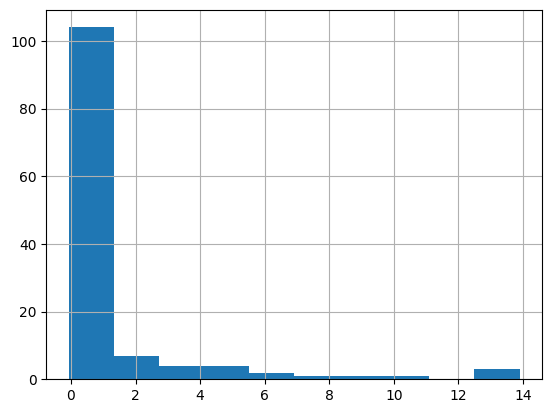

In [18]:
df["pre_icu_length_of_stay"].hist()

In [19]:
print(f"Percentage of ICU admissions within 1 day: \
        {len(df[df['pre_icu_length_of_stay']<1])/len(df)*100:.2f}%")

Percentage of ICU admissions within 1 day:         81.10%


You can find the SQL that performs a similar query on BigQuery in [this tutorial](https://mimic.mit.edu/docs/iii/tutorials/intro-to-mimic-iii-bq/#solution-to-step-4).

### Working with Text: Parsing through clinical diagnosis

Electronic health records can include both structured data (such as clinical measurements of temperature, blood pressure, etc.) and unstructured data (such as imaging, physician notes, etc.). For example, take a look at the [`diagnosis` column](https://mimic.mit.edu/docs/iii/tables/admissions/#diagnosis), which contains free-text diagnosis assigned by the clinician:

In [20]:
df.diagnosis

0                                                 SEPSIS
1                                            HEPATITIS B
2                                                 SEPSIS
3                                       HUMERAL FRACTURE
4                                    ALCOHOLIC HEPATITIS
                             ...                        
122                                  SHORTNESS OF BREATH
123                                 PERICARDIAL EFFUSION
124    ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...
125                                          BRADYCARDIA
126                                          CHOLANGITIS
Name: diagnosis, Length: 127, dtype: object

Thankfully, it is easy to work with text data in pandas, since pandas comes with a [convenient set of functions](https://pandas.pydata.org/docs/user_guide/text.html) for operating with string and object type columns. 

Here, we normalize the text by replacing special characters and custom separators with spaces. Then we combine all diagnoses of all the patients together to determine the top 5 words that are used in the diagnoses.

In [21]:
df.diagnosis = df.diagnosis.str.replace(";"," ").str.strip()
all_diagnosis_str = df.diagnosis.str.cat(sep=" ")

subs = {"\\":" ", "-":"", "/":"", "?":""}
for s in subs.keys(): 
    all_diagnosis_str = all_diagnosis_str.replace(s, subs[s])

all_diagnosis = all_diagnosis_str.split(" ")

In [22]:
import collections
c = collections.Counter(all_diagnosis)
c.most_common(5)

[('FAILURE', 12), ('SEPSIS', 11), ('PNEUMONIA', 9), ('BLEED', 8), ('ACUTE', 7)]

In [23]:
top_5_keyword = sorted(c, key=c.get, reverse=True)[:5]
print(f"Top 5 most common diagnostic terms are: {top_5_keyword}")

Top 5 most common diagnostic terms are: ['FAILURE', 'SEPSIS', 'PNEUMONIA', 'BLEED', 'ACUTE']


Based on these top five words, we create a binary feature that indicates the presence of each diagnostic term. 

In [24]:
for keyword in top_5_keyword:
    df[keyword]=df['diagnosis'].str.contains(keyword)

[Survivial analysis](https://www.nature.com/articles/s41746-022-00679-6) and [mortality prediction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4321691/) are common use cases by researchers and clinicians for analyzing electronic health data, especially as it pertains to ICU stays.

Now with all the diagnostic features we created, we build a basic machine learning model to predict the likelihood of survival of patients. 

The `hospital_expire_flag` is a binary attribute that captures whether a patient died in the hospital. By printing out the [value counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) of this attribute, we see that about a third of ICU patients die in the hospital. 

In [25]:
df["hospital_expire_flag"].value_counts()

hospital_expire_flag
0    85
1    42
Name: count, dtype: int64

In [26]:
X = df[top_5_keyword].astype(int)
y = df['hospital_expire_flag']

In [27]:
dataset = pd.concat([X,y],axis=1)
dataset = dataset.rename(columns={"hospital_expire_flag":"TARGET"})

In [28]:
dataset

,FAILURE,SEPSIS,PNEUMONIA,BLEED,ACUTE,TARGET
0,0,1,0,0,0,0
1,0,0,0,0,0,1
2,0,1,0,0,0,1
3,0,0,0,0,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
122,0,0,0,0,0,0
123,0,0,0,0,0,0
124,1,0,0,0,1,0
125,0,0,0,0,0,0


We save the result of our preprocessed data as a table in Snowflake called `ICU_MORTALITY`. This allow us to use Snowpark with the dataset we've preprocessed with Ponder.

In [29]:
dataset.to_sql("ICU_MORTALITY",con=snowflake_con, index = None, if_exists="replace")

### Machine Learning in the Database with Snowpark ML: Mortality prediction of ICU Patients

Next, we build a machine learning model with Snowpark ML to predict patient mortality of ICU patients.

### What is Snowpark ML Modeling? 
Snowpark ML Modeling gives users a Python interface for preprocessing and training models. Similar to how Ponder runs all your pandas operations directly in Snowflake, Snowpark ML modeling runs all your Python ML operations directly in Snowflake. Unlike Ponder, this is done by registering your Python models as user-defined function to be executed on the database. This means that data doesn't leave your warehouse and you inherit the scale, performance, and security you get with Snowflake. (Note: While Snowpark ML supports preprocessing procedures, since we already performed all the preprocessing in pandas using Ponder, we only use the modeling APIs here)

We build a binary classification model, where `X` is our features (i.e., presence of diagnostic terms) and `y` is the target (i.e., predict if patient dies in the hospital). 

First, we use Snowpark to load in the `ICU_MORTALITY` table from earlier.

In [30]:
from snowflake.snowpark import Session
session = Session.builder.configs(credential.params).create()

In [31]:
dataset = session.table("ICU_MORTALITY")
dataset.show()

---------------------------------------------------------------------
|"FAILURE"  |"SEPSIS"  |"PNEUMONIA"  |"BLEED"  |"ACUTE"  |"TARGET"  |
---------------------------------------------------------------------
|0          |1         |0            |0        |0        |0         |
|0          |0         |0            |0        |0        |1         |
|0          |1         |0            |0        |0        |1         |
|0          |0         |0            |0        |0        |0         |
|0          |0         |0            |0        |0        |1         |
|0          |0         |0            |0        |0        |0         |
|0          |0         |0            |0        |0        |0         |
|0          |0         |0            |0        |0        |0         |
|0          |0         |0            |0        |0        |0         |
|0          |0         |0            |0        |0        |0         |
---------------------------------------------------------------------



Next, we split the data into training and test sets. We hold out 10% of the data for testing the model and use the remaining dataset for training.

This is the sci-kit learn code for performing the same task as below: 

```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1,random_state=0)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
```

(Note: It seems like Snowpark ML's `random_split` work slightly differently than sklearn's `train_test_split`. The weights had to be set as 0.88/0.11 to equal size of the 0.9/0.1 split that we did with sklearn.)

In [33]:
# Split the data into train and test sets
train_df, test_df = dataset.random_split(weights=[0.88, 0.12], seed=0)

In [34]:
print (f"Training size: {train_df.count()} , Test size: {test_df.count()}")

Training size: 114 , Test size: 13


Now, we are ready to build our model. The Snowpark ML API is largely inspired by three popular Python ML libraries: scikit-learn, xgboost, and lightgbm. In this blogpost, we will only be using the scikit-learn APIs. We will show the corresponding code for performing the same operation in scikit-learn. You may note some key differences, in particular, in the model initialization step, Snowpark requires that you specify the input and label columns upfront (i.e., input being the features and label being the target variable you are trying to predict). In scikit-learn, you will notice that this happens on the `fit` step rather than in the model definition step. You can read more about the API differences [here](https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-modeling#general-api-differences).

In [35]:
from snowflake.ml.modeling.naive_bayes import GaussianNB

In [36]:
model = GaussianNB(input_cols=['FAILURE', 'SEPSIS', 'PNEUMONIA', 'BLEED', 'ACUTE'],label_cols="TARGET")

We fit a basic [Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) and evaluate the model predictions.

In [37]:
model = model.fit(train_df)

In [38]:
predictions = model.predict(test_df)

After the predict step, we can print out the Snowpark dataframe. Here we see that a new column called `OUTPUT_TARGET` has been created, which includes the predictions made by the model (remember that `TARGET` is the true labels from our original dataset).

In [39]:
predictions.show()

---------------------------------------------------------------------------------------
|"TARGET"  |"SEPSIS"  |"PNEUMONIA"  |"ACUTE"  |"BLEED"  |"FAILURE"  |"OUTPUT_TARGET"  |
---------------------------------------------------------------------------------------
|1         |0         |0            |0        |1        |0          |1                |
|0         |0         |0            |0        |0        |0          |1                |
|1         |0         |0            |0        |0        |0          |1                |
|1         |0         |0            |0        |0        |0          |1                |
|0         |1         |1            |0        |0        |0          |0                |
|0         |0         |0            |0        |0        |0          |1                |
|0         |0         |1            |0        |0        |0          |0                |
|0         |0         |0            |0        |0        |0          |1                |
|0         |1         |0        

In the quick preview above, we can see that the model was able to predict the target correctly for most of the rows, but there are two rows that are incorrectly predicted (rows 2 and 8). So how well did our model do? 

To understand this, we plot the confusion matrix to show the number of true positives, true negatives, false positives and false negatives.

Here is the corresponding code with sklearn:

```python
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
```

We compute the confusion matrix with Snowpark: 

In [40]:
from snowflake.ml.modeling.metrics import confusion_matrix
cm = confusion_matrix(df= predictions, y_pred_col_name= "OUTPUT_TARGET", y_true_col_name="TARGET")
cm

array([[3., 6.],
       [0., 4.]])

Since Snowpark ML doesn't currently support plotting confusion matrices, we use the `ConfusionMatrixDisplay` from sklearn.

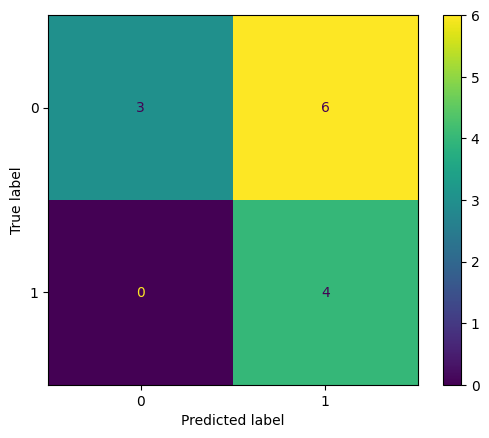

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Finally, we compute the accuracy score to see how well the model did. This is the code for sklearn: 

```python
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, predictions)
print(f'Accuracy of the binary classifier = {score:0.2f}')
```

Running this with Snowpark ML: 

In [42]:
from snowflake.ml.modeling.metrics import accuracy_score
score = accuracy_score(df= predictions, y_pred_col_names= "OUTPUT_TARGET", y_true_col_names="TARGET")
print(f'Accuracy of the binary classifier = {score:0.2f}')

Accuracy of the binary classifier = 0.54


Of course, we are working with a very small sample here, so this is mostly intended to be an illustrative example.

**Why Ponder + Snowpark ML?**

In this post, we saw how Ponder lets you analyze electronic health records with ease by allowing practitioners to: 
- browse high-level summary and overview of the dataset,
- discover patterns and insights based on visualizations and basic statistics,
- perform date time operations to compute patient's length of stay,
- develop features based on clinician free-text diagnosis.

Finally, we saw how Ponder integrates with Snowpark ML, enabling us to build a classification model to predict ICU patient mortality using a sklearn-like interface. With Ponder + Snowpark ML, you can seamlessly move between data analysis, transformation, feature engineering, visualization, and machine learning — all within the Python data ecosystem, while operating directly on the data in your data warehouse. 


Looking to try Ponder for your project? Sign up [here](https://app.ponder.io/signup) to get started in using Ponder!